In [ ]:
import os
import sys

# Add parent directory to path to import cgbench
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.5'
import numpy as np
from cgbench.utils import helpers as utils
import jax.numpy as jnp
import mdtraj as md
from jax_md import space
from cgbench.utils.analysis import *
import jax

In [6]:
BOX_LENGTH = 2.79573 # nm
box = jnp.identity(3) * BOX_LENGTH
disp_fn, shift_fn = space.periodic_general(
            box=box, fractional_coordinates=True
        )
disp_fn_X, shift_fn_X = space.periodic_general(
            box=box, fractional_coordinates=False
        )

In [7]:
import jax
import jax.numpy as jnp

def compute_bond_metrics(traj: np.ndarray, disp_X) -> tuple:
    """
    Optimized version using JAX vmap for displacement calculations.
    """
    n_frames = traj.shape[0]
    n_particles = traj.shape[1]
    
    # Convert to JAX array for vmap operations
    traj_jax = jnp.array(traj)
    
    # Vectorize displacement function over particles (j dimension)
    disp_X_vmap_j = jax.vmap(disp_X, in_axes=(None, 0))
    # Vectorize over frames
    disp_X_vmap_frames = jax.vmap(disp_X_vmap_j, in_axes=(0, 0))
    
    # Compute all pairwise displacements and distances
    dist_matrix = np.full((n_frames, n_particles, n_particles), np.inf)
    
    # Loop over i particles, but vectorize over frames and j particles
    for i in range(n_particles):
        # For particle i, compute distances to all other particles across all frames
        Ra = traj_jax[:, i, :]  # [n_frames, 3]
        Rb = traj_jax  # [n_frames, n_particles, 3]
        
        # Compute displacements for all j particles at once, across all frames
        disp = disp_X_vmap_frames(Ra, Rb)  # [n_frames, n_particles, 3]
        distances = jnp.linalg.norm(disp, axis=-1)  # [n_frames, n_particles]
        
        dist_matrix[:, i, :] = np.array(distances)
    
    # Set diagonal to infinity
    dist_matrix[:, np.arange(n_particles), np.arange(n_particles)] = np.inf
    
    # Find nearest neighbors
    nn_idx = np.argmin(dist_matrix, axis=-1)  # [n_frames, n_particles]
    nn_dist = np.take_along_axis(dist_matrix, nn_idx[..., np.newaxis], axis=-1).squeeze(-1)
    
    # Detect switches
    switches = np.diff(nn_idx, axis=0, prepend=nn_idx[0:1]) != 0
    ever_switched = np.cumsum(switches, axis=0) > 0
    cumulative_fraction = np.sum(ever_switched, axis=1) / float(n_particles)
    cumulative_fraction[0] = 0.0
    
    # Find mutual nearest neighbors (bonds)
    mutual_nn = nn_idx[np.arange(n_frames)[:, None], nn_idx] == np.arange(n_particles)
    
    bonds_per_frame = []
    for f in range(n_frames):
        i_idx = np.where(mutual_nn[f])[0]
        j_idx = nn_idx[f, i_idx]
        valid = i_idx < j_idx
        pairs = np.column_stack([i_idx[valid], j_idx[valid]])
        bonds_per_frame.append(pairs.tolist())
    
    nearest_neighbor_distances = nn_dist.T
    
    return cumulative_fraction, nearest_neighbor_distances, bonds_per_frame

In [8]:
def mark_nan(traj: np.ndarray, aux: np.ndarray, threshold: float = 5) -> np.ndarray:
    """
    Mark trajectory data as NaN from the point where auxiliary data exceeds threshold.
    
    For each chain, if any auxiliary value exceeds the threshold, all trajectory data
    from that point onward in that chain is set to NaN.
    
    Args:
        traj: Trajectory array of shape (n_chains, n_frames, n_atoms, 3)
        aux: Auxiliary data array of shape (n_chains, n_frames)
        threshold: Threshold value for auxiliary data
    
    Returns:
        np.ndarray: Modified trajectory with NaN values where aux exceeded threshold
    """
    traj_marked = traj.copy()
    
    for chain_idx in range(aux.shape[0]):
        exceeded = aux[chain_idx] > threshold
        
        if np.any(exceeded):
            print(f"Chain {chain_idx} exceeded threshold")
            first_exceed_frame = np.argmax(exceeded)
            
            traj_marked[chain_idx, first_exceed_frame:] = np.nan
    
    return traj_marked


def calculate_stability(traj_marked: np.ndarray, print_every=0.5):
    """
    Calculate stability metrics from a trajectory with NaN values.
    
    Computes the mean and standard deviation of the number of valid frames
    (before NaN occurs) for each chain in the trajectory.
    
    Args:
        traj_marked: Trajectory array of shape (n_chains, n_frames, n_atoms, 3)
                     with NaN values marking unstable regions
    
    Returns:
        tuple: (mean_length, std_length)
            - mean_length: Mean number of frames before NaN occurs across all chains
            - std_length: Standard deviation of frames before NaN occurs
    """
    n_chains, n_frames = traj_marked.shape[0], traj_marked.shape[1]
    valid_lengths = []
    
    for chain_idx in range(n_chains):
        # Check if any NaN exists in this chain (check first coordinate of first atom)
        chain_data = traj_marked[chain_idx, :, 0, 0]
        nan_mask = np.isnan(chain_data)
        
        if np.any(nan_mask):
            # Find first NaN occurrence
            first_nan_frame = np.argmax(nan_mask)
            valid_lengths.append(first_nan_frame*print_every)
        else:
            # Chain remained stable throughout
            valid_lengths.append(n_frames*print_every)
    
    mean_length = np.mean(valid_lengths)
    std_length = np.std(valid_lengths)
    
    return mean_length, std_length

# Prep

## File paths

In [19]:
paths_four = {
    'N=10': {
        'corr=1': 'Hexane/MLP/Hexane_map=four-site_rcut=0.55_corr=1_int=2/simulation_NVT_T=300.0K/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=50_mode=sampling_seed=22/trajectory.pkl',
        'corr=2': 'Hexane/MLP/Hexane_map=four-site_rcut=0.55_corr=2_int=2/simulation_NVT_T=300.0K/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=50_mode=sampling_seed=22/trajectory.pkl',
        'corr=3': 'Hexane/MLP/Hexane_map=four-site_rcut=0.55_corr=3_int=2/simulation_NVT_T=300.0K/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=50_mode=sampling_seed=22/trajectory.pkl',
    },
    'N=20': {
        'corr=1': 'Hexane/MLP/Hexane_map=four-site_rcut=0.65_corr=1_int=2/simulation_NVT_T=300.0K/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=50_mode=sampling_seed=22/trajectory.pkl',
        'corr=2': 'Hexane/MLP/Hexane_map=four-site_rcut=0.65_corr=2_int=2/simulation_NVT_T=300.0K/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=50_mode=sampling_seed=22/trajectory.pkl',
        'corr=3': 'Hexane/MLP/Hexane_map=four-site_rcut=0.65_corr=3_int=2/simulation_NVT_T=300.0K/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=50_mode=sampling_seed=22/trajectory.pkl',
    },
}

paths_three = {
    'N=10': {
        'corr=1': 'Hexane/MLP/Hexane_map=three-site_rcut=0.55_corr=1_int=2/simulation_NVT_T=300.0K/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=50_mode=sampling_seed=22/trajectory.pkl',
        'corr=2': 'Hexane/MLP/Hexane_map=three-site_rcut=0.55_corr=2_int=2/simulation_NVT_T=300.0K/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=50_mode=sampling_seed=22/trajectory.pkl',
        'corr=3': 'Hexane/MLP/Hexane_map=three-site_rcut=0.55_corr=3_int=2/simulation_NVT_T=300.0K/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=50_mode=sampling_seed=22/trajectory.pkl',
    },
    'N=20': {
        'corr=1': 'Hexane/MLP/Hexane_map=three-site_rcut=0.7_corr=1_int=2/simulation_NVT_T=300.0K/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=50_mode=sampling_seed=22/trajectory.pkl',
        'corr=2': 'Hexane/MLP/Hexane_map=three-site_rcut=0.7_corr=2_int=2/simulation_NVT_T=300.0K/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=50_mode=sampling_seed=22/trajectory.pkl',
        'corr=3': 'Hexane/MLP/Hexane_map=three-site_rcut=0.7_corr=3_int=2/simulation_NVT_T=300.0K/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=50_mode=sampling_seed=22/trajectory.pkl',
    },
}

paths_two = {
    'N=10': {
        'corr=1': 'Hexane/MLP/Hexane_map=two-site_rcut=0.65_corr=1_int=2/simulation_NVT_T=300.0K/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=50_mode=sampling_seed=22/trajectory.pkl',
        'corr=2': 'Hexane/MLP/Hexane_map=two-site_rcut=0.65_corr=2_int=2/simulation_NVT_T=300.0K/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=50_mode=sampling_seed=22/trajectory.pkl',
        'corr=3': 'Hexane/MLP/Hexane_map=two-site_rcut=0.65_corr=3_int=2/simulation_NVT_T=300.0K/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=50_mode=sampling_seed=22/trajectory.pkl',
    },
    'N=20': {
        'corr=1': 'Hexane/MLP/Hexane_map=two-site_rcut=0.8_corr=1_int=2/simulation_NVT_T=300.0K/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=50_mode=sampling_seed=22/trajectory.pkl',
        'corr=2': 'Hexane/MLP/Hexane_map=two-site_rcut=0.8_corr=2_int=2/simulation_NVT_T=300.0K/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=50_mode=sampling_seed=22/trajectory.pkl',
        'corr=3': 'Hexane/MLP/Hexane_map=two-site_rcut=0.8_corr=3_int=2/simulation_NVT_T=300.0K/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=50_mode=sampling_seed=22/trajectory.pkl',
        },
}


## Utils functions, indices 

In [10]:
dihedral_util = {}
angle_util = {}
bond_util = {}
species_util = {}

results = {}

### Two-site

In [11]:
Bond_pairs = [(0,1)]
sites_per_mol = 2
A_idx = [0, 1]
nmol = 100
species = []

Bonds_all = []
A_indices = []
for m in range(nmol):
    offset = m * sites_per_mol
    Bonds_all.extend([(a+offset, b+offset) for (a,b) in Bond_pairs])
    A_indices.extend([a+offset for a in A_idx])
    species.extend([0, 0])  # Assuming species 0 for A and 1 for B

species = jnp.array(species)
bond_util['two-site'] = {
    'disp_X': disp_fn_X,
    'disp_U': disp_fn,
    'idcs': Bonds_all,
}
species_util['two-site'] = species

### Three-site

In [12]:
Bond_pairs = [(0,1),(1,2)]
sites_per_mol = 3
angle_idcs = [(0,1,2)]
A_idx = [0, 2]
B_idx = [1]
nmol = 100
species = []

Angles_all = []
Bonds_all = []
A_indices = []
B_indices = []
for m in range(nmol):
    offset = m * sites_per_mol
    Angles_all.extend([tuple(i+offset for i in tri) for tri in angle_idcs])
    Bonds_all.extend([(a+offset, b+offset) for (a,b) in Bond_pairs])
    A_indices.extend([a+offset for a in A_idx])
    B_indices.extend([b+offset for b in B_idx])
    species.extend([0, 1, 0])  # Assuming species 0 for A and 1 for B
    
species= jnp.array(species)
hex_angle_fn = utils.init_angle_fn(disp_fn, Angles_all)  
hex_angle_fn_X = utils.init_angle_fn(disp_fn_X, Angles_all)

bond_util['three-site'] = {
    'disp_X': disp_fn_X,
    'disp_U': disp_fn,
    'idcs': jnp.array(Bonds_all),
}
angle_util['three-site'] = {
    'disp_X': hex_angle_fn_X,
    'disp_U': hex_angle_fn,
    'idcs': jnp.array(Angles_all),
}
species_util['three-site'] = species

### Four-site

In [13]:
Bond_pairs = [(0,1),(1,2)]
angle_idcs = [(0,1,2),(1,2,3)]
dihedral_idcs = [(0,1,2,3)]

sites_per_mol = 4
A_idx = [0, 3]
B_idx = [1, 2]
nmol = 100
species = []

Dihedrals_idcs_all = []
Angles_idcs_all = []

Angles_all = []
Bonds_all = []
Dihedrals_all = []
A_indices = []
B_indices = []
for m in range(nmol):
    offset = m * sites_per_mol
    Angles_all.extend([tuple(i+offset for i in tri) for tri in angle_idcs])
    Bonds_all.extend([(a+offset, b+offset) for (a,b) in Bond_pairs])
    Dihedrals_all.extend([(a+offset, b+offset, c+offset, d+offset) for (a,b,c,d) in dihedral_idcs])
    
    A_indices.extend([a+offset for a in A_idx])
    B_indices.extend([b+offset for b in B_idx])
    species.extend([0, 1, 1, 0])  # Assuming species 0 for A and 1 for B
    
species= jnp.array(species)

hex_angle_fn = utils.init_angle_fn(disp_fn, Angles_all)  
hex_angle_fn_X = utils.init_angle_fn(disp_fn_X, Angles_all)

hex_dihedral_fn_0123 = utils.init_dihedral_fn(disp_fn, Dihedrals_all)
hex_dihedral_fn_0123_X = utils.init_dihedral_fn(disp_fn_X, Dihedrals_all)

dihedral_util['four-site'] = {
    'disp_X': hex_dihedral_fn_0123_X,
    'disp_U': hex_dihedral_fn_0123,
    'idcs': Dihedrals_all
}

angle_util['four-site'] = {
    'disp_X': hex_angle_fn_X,
    'disp_U': hex_angle_fn,
    'idcs': Angles_all
}

bond_util['four-site'] = {
    'disp_X': disp_fn_X,
    'disp_U': disp_fn,
    'idcs': Bonds_all
}

species_util['four-site'] = species

# Additive vs MACE

## Three-site

### Ref

In [ ]:
path = "Reference_simulations/hexane/hexane_ttot=100ns_dt=1fs_nstxout=200_CG=three-site.npz"
data = dict(np.load(path,allow_pickle=True))
ref_traj = np.concatenate([data['arr_0'].item()['training']['R'],data['arr_0'].item()['validation']['R']])

angles_ref = angle_util['three-site']['disp_X'](ref_traj)  # [N_angle_idcs, n_frames]
angles_ref = np.radians(np.concatenate(angles_ref))
angles_ref = np.concatenate([angles_ref, angles_ref])

bond_ref = [utils.compute_atom_distance(ref_traj, a, b, bond_util['three-site']['disp_X']) for a,b in bond_util['three-site']['idcs']]
bond_ref = np.concatenate(bond_ref)

results['three-site'] = {
    'ref': {
        'angles': angles_ref,
        'bonds': bond_ref,
        'traj': ref_traj
    }
} 

### Classical

In [69]:
base_path = "Hexane/Classical_potential/model/map=three-site/chain_"
trajectories = []
for chain_idx in range(10):
    print(f"Loading chain {chain_idx}")
    traj_path = base_path + str(chain_idx) + "/traj.xtc"
    conf_path = base_path + str(chain_idx) + "/cg_hexane.gro"
    traj = md.load(traj_path, top=conf_path).xyz
    trajectories.append(traj)
trajectories = np.array(trajectories)


idcs = jnp.array(bond_util['three-site']['idcs'])
def single_bond_distance(chain, bond_idx):
    a, b = bond_idx
    return utils.compute_atom_distance(chain, a, b, bond_util['three-site']['disp_X'])
vmap_bond = jax.vmap(single_bond_distance, in_axes=(None, 0))  
vmap_chain = jax.vmap(vmap_bond, in_axes=(0, None))  
bonds_classical = vmap_chain(jnp.array(trajectories), jnp.array(bond_util['three-site']['idcs']))
bonds_classical = bonds_classical.reshape(bonds_classical.shape[0], -1)

hex_angle_fn_X_vmap = jax.vmap(angle_util['three-site']['disp_X'], in_axes=(0,))
angles_classical = hex_angle_fn_X_vmap(jnp.array(trajectories))  # [N_angle_idcs, n_frames]
angles_classical = angles_classical.reshape(angles_classical.shape[0], -1)
angles_classical = np.radians(angles_classical)

results['three-site']['classical'] = {
    'bonds': bonds_classical,
    'angles': angles_classical,
    'traj': trajectories
}

Loading chain 0
Loading chain 1
Loading chain 2
Loading chain 3
Loading chain 4
Loading chain 5
Loading chain 6
Loading chain 7
Loading chain 8
Loading chain 9


### MACE

In [184]:
line_locs = utils.get_line_locations(0, 1000, 50, print_every=0.5)

results['three-site']['mace'] = {}
for N in paths_three.keys():
    results['three-site']['mace'][N] = {}
    
    for bo in paths_three[N].keys():
        print('\n')
        if paths_three[N][bo] == '':
            print(f"Three-site {N}, {bo}: No data")
            continue
        print(f"Three-site {N}, {bo}: {paths_three[N][bo]}")

        mace_traj_path = paths_three[N][bo]
        mace_traj = np.load(mace_traj_path, allow_pickle=True)
        mace_traj *= box[0,0]
        mace_traj = utils.split_into_chains(mace_traj, line_locs)
        
        aux_path = mace_traj_path.replace('trajectory.pkl','traj_state_aux.pkl')
        aux_data = np.load(aux_path, allow_pickle=True)['kT']
        aux_data = utils.split_into_chains(aux_data, line_locs)
        
        mace_traj = mark_nan(mace_traj, aux_data, threshold=5)
        mean_length, std_length = calculate_stability(mace_traj)
        print(f"Mean stable length: {mean_length} ± {std_length} ps")

        rdf_data, bead_combos = calculate_rdf(
            [results['three-site']['ref']['traj']] + list(mace_traj),
            ['A','B','A'], 
            sites_per_mol=3,
            pair_batch_size=10_000,
            frame_batch_size=1_000 
        )
        
        valid_chain_mask = np.array([~np.isnan(chain).any() for chain in mace_traj])
        mace_traj_valid = [chain for chain, ok in zip(mace_traj, valid_chain_mask) if ok]

        print(f"Valid chains kept: {len(mace_traj_valid)} / {len(mace_traj)}")
        if len(mace_traj_valid) == 0:
            print("No valid chains remain after NaN filtering.")
            continue
        
        hex_angle_fn_X_vmap = jax.vmap(angle_util['three-site']['disp_X'], in_axes=(0,))
        angles_mace = hex_angle_fn_X_vmap(jnp.array(mace_traj_valid))
        angles_mace = angles_mace.reshape(angles_mace.shape[0], -1)
        angles_mace = np.radians(angles_mace)
        
        vmap_bond = jax.vmap(single_bond_distance, in_axes=(None, 0))  
        vmap_chain = jax.vmap(vmap_bond, in_axes=(0, None))  
        bonds_mace = vmap_chain(jnp.array(mace_traj_valid), jnp.array(bond_util['three-site']['idcs']))
        bonds_mace = bonds_mace.reshape(bonds_mace.shape[0], -1)
        
        print("bonds_mace.shape:", bonds_mace.shape)
        print("angles_mace.shape:", angles_mace.shape)
        
        results['three-site']['mace'][N][bo] = {
            'bonds': bonds_mace,
            'angles': angles_mace,
            'traj': mace_traj_valid,
            'rdf_data': rdf_data,
            'bead_combos': bead_combos
        }
        
        assert calculate_rdf_mse_from_dict(rdf_data, ('A', 'A'), 0, 0) == 0 
        
        for bead_combo in bead_combos:
            MSE = []
            for i in range(1, len(mace_traj)+1):
                RDF_MSE = calculate_rdf_mse_from_dict(
                    rdf_data, 
                    bead_combo, 
                    0, 
                    i
                )
                MSE.append(RDF_MSE)
            
            MEAN_MSE = np.mean(MSE)
            STD_MSE = np.std(MSE)
            print(f"Mean RDF {bead_combo} MSE across chains: {MEAN_MSE*1000} ± {STD_MSE*1000}")



Three-site N=10, corr=1: Hexane/MLP/Hexane_map=three-site_rcut=0.55_corr=1_int=2/simulation_NVT_T=300.0K/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=50_mode=sampling_seed=22/trajectory.pkl
Mean stable length: 1000.0 ± 0.0 ps
Valid chains kept: 50 / 50
bonds_mace.shape: (50, 400000)
angles_mace.shape: (50, 200000)
Mean RDF ('A', 'A') MSE across chains: 0.5135431787083108 ± 0.11659695592945883
Mean RDF ('A', 'B') MSE across chains: 0.3414135124164411 ± 0.05465525987851698
Mean RDF ('B', 'B') MSE across chains: 0.4357123940553926 ± 0.1422016914451583


Three-site N=10, corr=2: Hexane/MLP/Hexane_map=three-site_rcut=0.55_corr=2_int=2/simulation_NVT_T=300.0K/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=50_mode=sampling_seed=22/trajectory.pkl
Chain 0 exceeded threshold
Chain 1 exceeded threshold
Chain 2 exceeded threshold
Chain 3 exceeded threshold
Chain 4 exceeded threshold
Chain 5 exceeded threshold
Chain 6 exceeded threshold
Chain 7 exceeded threshold
Chain 8 exceeded thresh

Generated 3 RDF plots saved as PDF files.


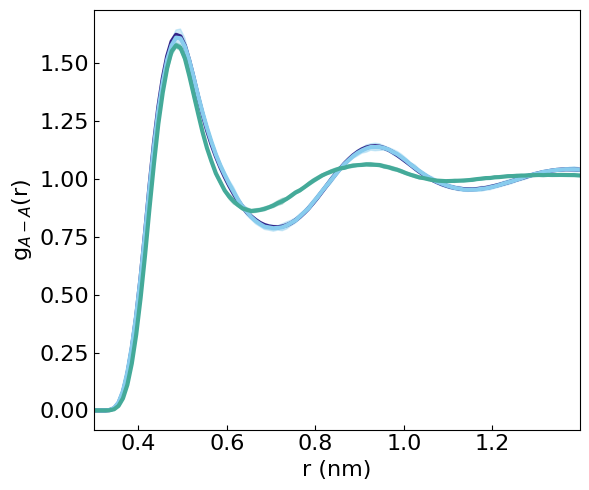

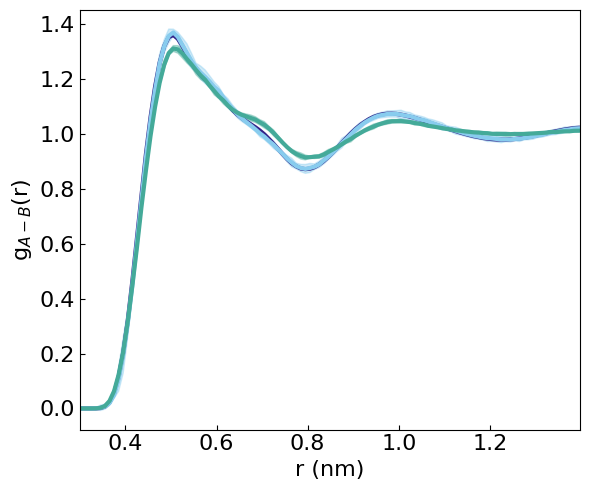

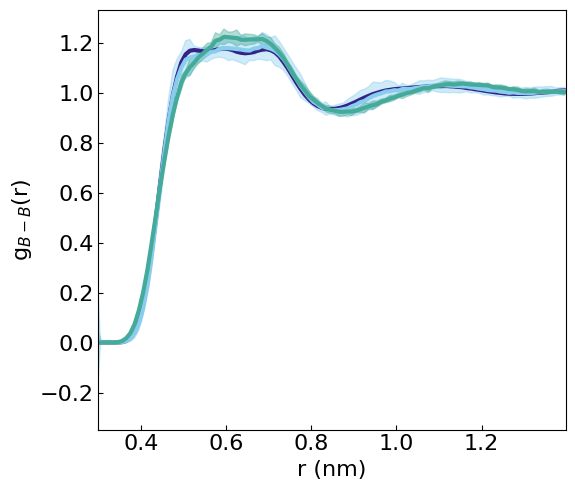

In [32]:
trajectories = [
    np.array(results['three-site']['ref']['traj']),
    np.array(results['three-site']['mace']['N=20']['corr=2']['traj']),
    np.array(results['three-site']['classical']['traj'])
]

labels = [
    'Reference',
    'MLP',
    'Classical'
]

n_chains = 10 # Only show 10 chains for ML models
is_single_chain = [traj.ndim == 3 for traj in trajectories]
rdf_data_all_chains = []

for chain in range(n_chains):
    trajs_single_chain = []
    for traj_chain, single in zip(trajectories, is_single_chain):
        if single:
            # Reference → do NOT index by chain
            trajs_single_chain.append(traj_chain)
        else:
            # ML models → pick chain
            trajs_single_chain.append(traj_chain[chain])

    rdf_data_chain, bead_combos = calculate_rdf(
        trajs_single_chain,
        ['A','B','A'],
        sites_per_mol=3,
        pair_batch_size=10_000,
        frame_batch_size=1_000
    )
    rdf_data_all_chains.append(rdf_data_chain)


merged_rdf = {}

for bead_combo in bead_combos:
    merged_rdf[bead_combo] = {}

    for traj_idx in range(len(trajectories)):

        chain_curves = []
        for chain_idx in range(n_chains):
            r, g_r = rdf_data_all_chains[chain_idx][bead_combo][traj_idx]
            chain_curves.append((r, g_r))

        merged_rdf[bead_combo][traj_idx] = chain_curves


for bead_combo in bead_combos:
    for traj_idx in merged_rdf[bead_combo]:
        curves = merged_rdf[bead_combo][traj_idx]

        r_vals = np.array([c[0] for c in curves])   # shape (n_chains, bins)
        g_vals = np.array([c[1] for c in curves])   # shape (n_chains, bins)

        merged_rdf[bead_combo][traj_idx] = (r_vals, g_vals)
        
results['three-site']['rdf'] = merged_rdf

plot_rdf(
    merged_rdf,
    bead_combos,
    labels,
    mode="multi",  
    n_std=3.0,
    show_legend=False,
    save_pdf=False
)

## Two-site

### Ref

In [35]:
path = "Reference_simulations/hexane/hexane_ttot=100ns_dt=1fs_nstxout=200_CG=two-site.npz"
data = dict(np.load(path,allow_pickle=True))
ref_traj = np.concatenate([data['arr_0'].item()['training']['R'],data['arr_0'].item()['validation']['R']])

bond_ref = [utils.compute_atom_distance(ref_traj, a, b, bond_util['two-site']['disp_X']) for a,b in bond_util['two-site']['idcs']]
bond_ref = np.concatenate(bond_ref)

results['two-site'] = {
    'ref': {
        'bonds': bond_ref,
        'traj': ref_traj
    }
}

In [36]:
idcs = jnp.array(bond_util['two-site']['idcs'])
def single_bond_distance(chain, bond_idx):
    a, b = bond_idx
    return utils.compute_atom_distance(chain, a, b, bond_util['two-site']['disp_X'])

### Classical

In [ ]:
base_path = "Hexane/Classical_potential/model/map=two-site/chain_"
trajectories = []
for chain_idx in range(10):
    print(f"Loading chain {chain_idx}")
    traj_path = base_path + str(chain_idx) + "/traj.xtc"
    conf_path = base_path + str(chain_idx) + "/cg_hexane.gro"
    traj = md.load(traj_path, top=conf_path).xyz
    trajectories.append(traj)

trajectories = np.array(trajectories)
vmap_bond = jax.vmap(single_bond_distance, in_axes=(None, 0))  
vmap_chain = jax.vmap(vmap_bond, in_axes=(0, None))  
bonds_classical = vmap_chain(jnp.array(trajectories), idcs)
bonds_classical = bonds_classical.reshape(bonds_classical.shape[0], -1)

results['two-site']['classical'] = {
    'bonds': bonds_classical,
    'traj': trajectories
}

Loading chain 0
Loading chain 1
Loading chain 2
Loading chain 3
Loading chain 4
Loading chain 5
Loading chain 6
Loading chain 7
Loading chain 8
Loading chain 9


### MACE

In [41]:
line_locs = utils.get_line_locations(0, 1000, 50, print_every=0.5)
results['two-site']['mace'] = {}

for N in paths_two.keys():
    results['two-site']['mace'][N] = {}
    
    for bo in paths_two[N].keys():
        if paths_two[N][bo] == '':
            print(f"Two-site {N}, {bo}: No data")
            continue
        print(f"Two-site {N}, {bo}: {paths_two[N][bo]}")

        mace_traj_path = paths_two[N][bo]
        mace_traj = np.load(mace_traj_path, allow_pickle=True)
        mace_traj *= box[0,0]
        mace_traj = utils.split_into_chains(mace_traj, line_locs) # shape (n_chains, n_frames, n_beads, 3)
        
        aux_path = mace_traj_path.replace('trajectory.pkl','traj_state_aux.pkl')
        aux_data = np.load(aux_path, allow_pickle=True)['kT']
        aux_data = utils.split_into_chains(aux_data, line_locs)
        
        mace_traj = mark_nan(mace_traj, aux_data, threshold=5)
        mean_length, std_length = calculate_stability(mace_traj)
        print(f"Mean stable length: {mean_length} ± {std_length} ps")

        rdf_data, bead_combos = calculate_rdf(
            [results['two-site']['ref']['traj']] + list(mace_traj),
            ['A', 'A'], 
            sites_per_mol=2,
            pair_batch_size=10_000,
            frame_batch_size=1_000 
        )
        
        valid_chain_mask = np.array([~np.isnan(chain).any() for chain in mace_traj])
        mace_traj_valid = [chain for chain, ok in zip(mace_traj, valid_chain_mask) if ok]

        print(f"Valid chains kept: {len(mace_traj_valid)} / {len(mace_traj)}")
        if len(mace_traj_valid) == 0:
            print("No valid chains remain after NaN filtering.")
            continue
        
        vmap_bond = jax.vmap(single_bond_distance, in_axes=(None, 0))  
        vmap_chain = jax.vmap(vmap_bond, in_axes=(0, None))  
        bonds_mace = vmap_chain(jnp.array(mace_traj_valid), idcs)
        bonds_mace = bonds_mace.reshape(bonds_mace.shape[0], -1)
        print("bonds_mace.shape:", bonds_mace.shape)
        
        
        # Compute bond metrics for each chain
        cumulative_fractions = []
        nn_distances_list = []
        
        for chain_idx, chain_traj in enumerate(mace_traj_valid):
            cumulative_fraction, nearest_neighbor_distances, bonds_per_frame = \
                compute_bond_metrics(chain_traj, bond_util['two-site']['disp_X'])
            
            cumulative_fractions.append(cumulative_fraction)
            nn_distances_list.append(nearest_neighbor_distances)

        nn_distances_list = np.array(nn_distances_list)
        nn_distances_list = nn_distances_list.reshape(nn_distances_list.shape[0], -1)
        
        results['two-site']['mace'][N][bo] = {
            'bonds': bonds_mace,
            'traj': mace_traj_valid,
            'cumulative_switch_fraction': cumulative_fractions,
            'nn_distances': nn_distances_list
        }
        
        assert calculate_rdf_mse_from_dict(rdf_data, ('A', 'A'), 0, 0) == 0 
        
        for bead_combo in bead_combos:
            MSE = []
            for i in range(1, len(mace_traj)+1):
                RDF_MSE = calculate_rdf_mse_from_dict(
                    rdf_data, 
                    bead_combo, 
                    0, 
                    i
                )
                MSE.append(RDF_MSE)
            
            MEAN_MSE = np.mean(MSE)
            STD_MSE = np.std(MSE)
            print(f"Mean RDF {bead_combo} MSE across chains: {MEAN_MSE*1000} ± {STD_MSE*1000}")
        print('\n')

Two-site N=10, corr=1: Hexane/MLP/Hexane_map=two-site_rcut=0.65_corr=1_int=2/simulation_NVT_T=300.0K/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=50_mode=sampling_seed=22/trajectory.pkl
Mean stable length: 1000.0 ± 0.0 ps
Valid chains kept: 50 / 50
bonds_mace.shape: (50, 200000)
Mean RDF ('A', 'A') MSE across chains: 20.748064802858327 ± 3.0261824617020925


Two-site N=10, corr=2: Hexane/MLP/Hexane_map=two-site_rcut=0.65_corr=2_int=2/simulation_NVT_T=300.0K/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=50_mode=sampling_seed=22/trajectory.pkl
Mean stable length: 1000.0 ± 0.0 ps
Valid chains kept: 50 / 50
bonds_mace.shape: (50, 200000)
Mean RDF ('A', 'A') MSE across chains: 5.164795407237885 ± 3.2336761956190916


Two-site N=10, corr=3: Hexane/MLP/Hexane_map=two-site_rcut=0.65_corr=3_int=2/simulation_NVT_T=300.0K/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=50_mode=sampling_seed=22/trajectory.pkl
Mean stable length: 930.29 ± 188.82444465693524 ps
Valid chains kept: 43 / 

Generated 1 RDF plots saved as PDF files.


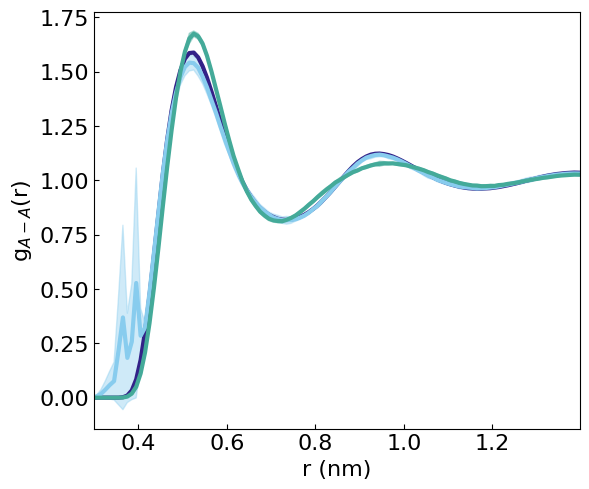

In [44]:
trajectories = [
    np.array(results['two-site']['ref']['traj']),
    np.array(results['two-site']['mace']['N=20']['corr=2']['traj']),
    np.array(results['two-site']['classical']['traj'])
]

labels = [
    'Reference',
    'MLP',
    'Classical'
]

n_chains = 10
is_single_chain = [traj.ndim == 3 for traj in trajectories]
rdf_data_all_chains = []

for chain in range(n_chains):
    trajs_single_chain = []
    for traj_chain, single in zip(trajectories, is_single_chain):
        if single:
            # Reference → do NOT index by chain
            trajs_single_chain.append(traj_chain)
        else:
            # ML models → pick chain
            trajs_single_chain.append(traj_chain[chain])

    rdf_data_chain, bead_combos = calculate_rdf(
        trajs_single_chain,
        ['A','A'],
        sites_per_mol=2,
        pair_batch_size=10_000,
        frame_batch_size=1_000
    )
    rdf_data_all_chains.append(rdf_data_chain)
    
merged_rdf = {}

for bead_combo in bead_combos:
    merged_rdf[bead_combo] = {}

    for traj_idx in range(len(trajectories)):

        chain_curves = []
        for chain_idx in range(n_chains):
            r, g_r = rdf_data_all_chains[chain_idx][bead_combo][traj_idx]
            chain_curves.append((r, g_r))

        merged_rdf[bead_combo][traj_idx] = chain_curves


for bead_combo in bead_combos:
    for traj_idx in merged_rdf[bead_combo]:
        curves = merged_rdf[bead_combo][traj_idx]

        r_vals = np.array([c[0] for c in curves])   # shape (n_chains, bins)
        g_vals = np.array([c[1] for c in curves])   # shape (n_chains, bins)

        merged_rdf[bead_combo][traj_idx] = (r_vals, g_vals)

results['two-site']['rdf'] = merged_rdf

plot_rdf(
    merged_rdf,
    bead_combos,
    labels,
    mode="multi",  
    n_std=3.0,
    show_legend=False,
    save_pdf=False
)


### plots

Processing bond data for 'Reference': (50000000,)
Processing bond data for 'Classical': (10, 200100)
Plotting bond distribution for 'Classical': 10 chains, mean=1.0, std sum=0.016047608952703393
Processing bond data for 'MLP': (50, 400000)
Plotting bond distribution for 'MLP': 50 chains, mean=1.0, std sum=0.01718434845383557


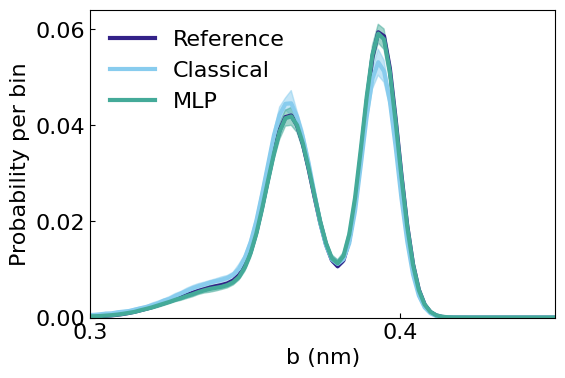

In [45]:
import importlib
import structural_analysis_utils
importlib.reload(structural_analysis_utils)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,4))
structural_analysis_utils.plot_1d_bond(
    ax,
    [
        results['two-site']['ref']['bonds'],
        results['two-site']['classical']['bonds'],
        results['two-site']['mace']['N=20']['corr=2']['nn_distances'],
    ],
    labels=[
        'Reference',
        'Classical',
        'MLP'
    ],
    mode = "multi",  
    n_std = 3,
    bins=200,
    tick_bin=0.1
)
plt.xlim(0.3,0.45)
plt.show()

## Four-site

In [72]:
path = "Reference_simulations/hexane/hexane_ttot=100ns_dt=1fs_nstxout=200_CG=four-site.npz"
data = dict(np.load(path,allow_pickle=True))
ref_traj = np.concatenate([data['arr_0'].item()['training']['R'],data['arr_0'].item()['validation']['R']])

angles_ref = angle_util['four-site']['disp_X'](ref_traj)  # [N_angle_idcs, n_frames]
angles_ref = np.radians(np.concatenate(angle_util['four-site']['disp_X'](ref_traj)))

dihedrals_ref = dihedral_util['four-site']['disp_X'](ref_traj)  # [N_dihedral_idcs, n_frames]
dihedrals_ref = np.concatenate(dihedral_util['four-site']['disp_X'](ref_traj))

bond_ref = [utils.compute_atom_distance(ref_traj, a, b, bond_util['four-site']['disp_X']) for a,b in bond_util['four-site']['idcs']]
bond_ref = np.concatenate(bond_ref)

results['four-site'] = {
    'ref': {
        'angles': angles_ref,
        'dihedrals': dihedrals_ref,
        'bonds': bond_ref,
        'traj': ref_traj
    }
}

In [73]:
idcs = jnp.array(bond_util['four-site']['idcs'])
def single_bond_distance(chain, bond_idx):
    a, b = bond_idx
    return utils.compute_atom_distance(chain, a, b, bond_util['four-site']['disp_X'])

In [74]:
base_path = "Hexane/Classical_potential/model/map=four-site/chain_"
trajectories = []
for chain_idx in range(10):
    print(f"Loading chain {chain_idx}")
    traj_path = base_path + str(chain_idx) + "/traj.xtc"
    conf_path = base_path + str(chain_idx) + "/cg_hexane.gro"
    traj = md.load(traj_path, top=conf_path).xyz
    trajectories.append(traj)

trajectories = np.array(trajectories)

vmap_bond = jax.vmap(single_bond_distance, in_axes=(None, 0))  
vmap_chain = jax.vmap(vmap_bond, in_axes=(0, None))  
bonds_classical = vmap_chain(jnp.array(trajectories), jnp.array(bond_util['four-site']['idcs']))
bonds_classical = bonds_classical.reshape(bonds_classical.shape[0], -1)

hex_angle_fn_X_vmap = jax.vmap(angle_util['four-site']['disp_X'], in_axes=(0,))
angles_classical = hex_angle_fn_X_vmap(jnp.array(trajectories))  # [N_angle_idcs, n_frames]
angles_classical = angles_classical.reshape(angles_classical.shape[0], -1)

hex_dihedral_fn_0123_X_vmap = jax.vmap(dihedral_util['four-site']['disp_X'], in_axes=(0,))
dihedrals_classical = hex_dihedral_fn_0123_X_vmap(jnp.array(trajectories))  # [N_dihedral_idcs, n_frames]
dihedrals_classical = dihedrals_classical.reshape(dihedrals_classical.shape[0], -1)

results['four-site']['classical'] = {
    'bonds': bonds_classical,
    'angles': angles_classical,
    'dihedrals': dihedrals_classical,
    'traj': trajectories
}

Loading chain 0
Loading chain 1
Loading chain 2
Loading chain 3
Loading chain 4
Loading chain 5
Loading chain 6
Loading chain 7
Loading chain 8
Loading chain 9


In [183]:
line_locs = utils.get_line_locations(0, 1000, 50, print_every=0.5)

results['four-site']['mace'] = {}
for N in paths_four.keys():
    results['four-site']['mace'][N] = {}
    
    for bo in paths_four[N].keys():
        
        print('\n')
        if paths_four[N][bo] == '':
            print(f"Four-site {N}, {bo}: No data")
            continue
        print(f"Four-site {N}, {bo}: {paths_four[N][bo]}")

        mace_traj_path = paths_four[N][bo]
        mace_traj = np.load(mace_traj_path, allow_pickle=True)
        mace_traj *= box[0,0]
        mace_traj = utils.split_into_chains(mace_traj, line_locs)
        
        aux_path = mace_traj_path.replace('trajectory.pkl','traj_state_aux.pkl')
        aux_data = np.load(aux_path, allow_pickle=True)['kT']
        aux_data = utils.split_into_chains(aux_data, line_locs)
        
        mace_traj = mark_nan(mace_traj, aux_data, threshold=5)
        mean_length, std_length = calculate_stability(mace_traj)
        print(f"Mean stable length: {mean_length} ± {std_length} ps")

        rdf_data, bead_combos = calculate_rdf(
            [results['four-site']['ref']['traj']] + list(mace_traj),
            ['A','B','B','A'], 
            sites_per_mol=4,
            pair_batch_size=10_000,
            frame_batch_size=1_000 
        )
        
        valid_chain_mask = np.array([~np.isnan(chain).any() for chain in mace_traj])
        mace_traj_valid = [chain for chain, ok in zip(mace_traj, valid_chain_mask) if ok]

        print(f"Valid chains kept: {len(mace_traj_valid)} / {len(mace_traj)}")
        if len(mace_traj_valid) == 0:
            print("No valid chains remain after NaN filtering.")
            continue
        
        hex_dihedral_fn_0123_X_vmap = jax.vmap(dihedral_util['four-site']['disp_X'], in_axes=(0,))
        dihedrals_mace = hex_dihedral_fn_0123_X_vmap(jnp.array(mace_traj_valid))  # (n_chains, n_beads, n_frames)
        dihedrals_mace = dihedrals_mace.reshape(dihedrals_mace.shape[0], -1) # (n_chains, n_beads * n_frames)

        hex_angle_fn_X_vmap = jax.vmap(angle_util['four-site']['disp_X'], in_axes=(0,))
        angles_mace = hex_angle_fn_X_vmap(jnp.array(mace_traj_valid))
        angles_mace = angles_mace.reshape(angles_mace.shape[0], -1)
        angles_mace = np.radians(angles_mace)
        
        vmap_bond = jax.vmap(single_bond_distance, in_axes=(None, 0))  
        vmap_chain = jax.vmap(vmap_bond, in_axes=(0, None))  
        bonds_mace = vmap_chain(jnp.array(mace_traj_valid), jnp.array(bond_util['four-site']['idcs']))
        bonds_mace = bonds_mace.reshape(bonds_mace.shape[0], -1)
        
        print("bonds_mace.shape:", bonds_mace.shape)
        print("angles_mace.shape:", angles_mace.shape)
        print("dihedrals_mace.shape:", dihedrals_mace.shape)
        
        results['four-site']['mace'][N][bo] = {
            'bonds': bonds_mace,
            'angles': angles_mace,
            'dihedrals': dihedrals_mace,
            'traj': mace_traj_valid,
            'rdf_data': rdf_data,
            'bead_combos': bead_combos
        }
        
        assert calculate_rdf_mse_from_dict(rdf_data, ('A', 'A'), 0, 0) == 0 
        
        for bead_combo in bead_combos:
            MSE = []
            for i in range(1, len(mace_traj)+1):
                RDF_MSE = calculate_rdf_mse_from_dict(
                    rdf_data, 
                    bead_combo, 
                    0, 
                    i
                )
                MSE.append(RDF_MSE)
            
            MEAN_MSE = np.mean(MSE)
            STD_MSE = np.std(MSE)
            print(f"Mean RDF {bead_combo} MSE across chains: {MEAN_MSE*1000} ± {STD_MSE*1000}")



Four-site N=10, corr=1: Hexane/MLP/Hexane_map=four-site_rcut=0.55_corr=1_int=2/simulation_NVT_T=300.0K/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=50_mode=sampling_seed=22/trajectory.pkl
Chain 0 exceeded threshold
Chain 1 exceeded threshold
Chain 2 exceeded threshold
Chain 3 exceeded threshold
Chain 4 exceeded threshold
Chain 5 exceeded threshold
Chain 6 exceeded threshold
Chain 7 exceeded threshold
Chain 8 exceeded threshold
Chain 9 exceeded threshold
Chain 10 exceeded threshold
Chain 11 exceeded threshold
Chain 12 exceeded threshold
Chain 13 exceeded threshold
Chain 14 exceeded threshold
Chain 15 exceeded threshold
Chain 16 exceeded threshold
Chain 17 exceeded threshold
Chain 18 exceeded threshold
Chain 19 exceeded threshold
Chain 20 exceeded threshold
Chain 21 exceeded threshold
Chain 22 exceeded threshold
Chain 23 exceeded threshold
Chain 24 exceeded threshold
Chain 25 exceeded threshold
Chain 26 exceeded threshold
Chain 27 exceeded threshold
Chain 28 exceeded threshold
Ch

Generated 3 RDF plots saved as PDF files.


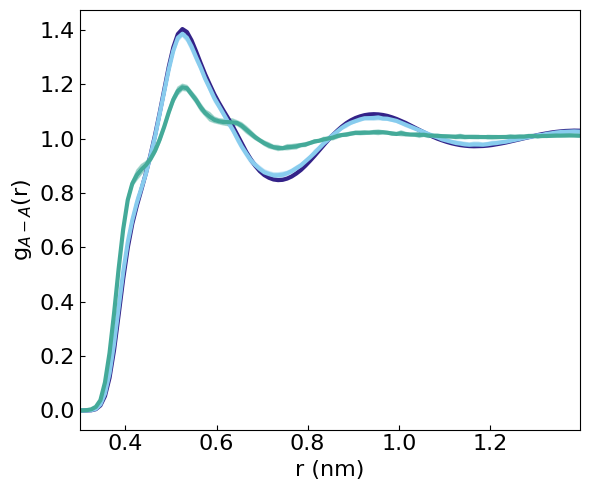

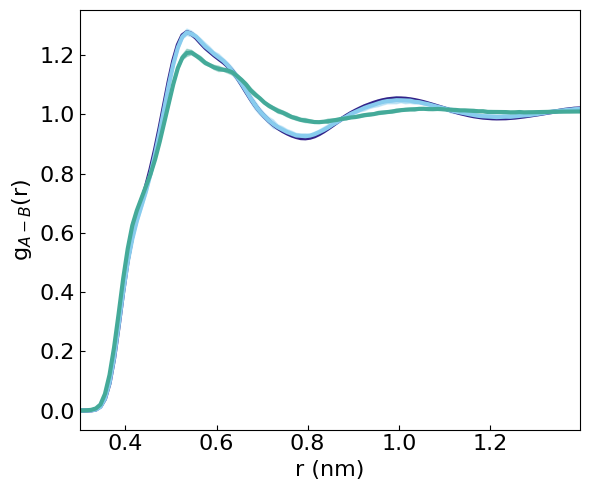

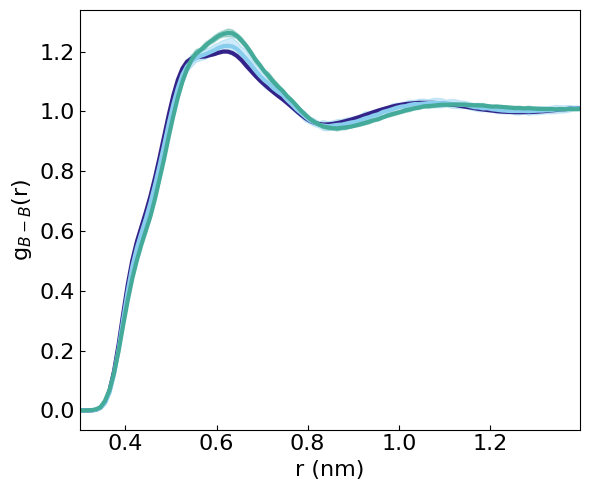

In [82]:
trajectories = [
    np.array(results['four-site']['ref']['traj']),
    np.array(results['four-site']['mace']['N=20']['corr=2']['traj']),
    np.array(results['four-site']['classical']['traj'])
]

labels = [
    'Reference',
    'MLP',
    'Classical'
]

n_chains = 10
is_single_chain = [traj.ndim == 3 for traj in trajectories]
rdf_data_all_chains = []

for chain in range(n_chains):
    trajs_single_chain = []
    for traj_chain, single in zip(trajectories, is_single_chain):
        if single:
            # Reference → do NOT index by chain
            trajs_single_chain.append(traj_chain)
        else:
            # ML models → pick chain
            trajs_single_chain.append(traj_chain[chain])

    rdf_data_chain, bead_combos = calculate_rdf(
        trajs_single_chain,
        ['A','B','B','A'],
        sites_per_mol=4,
        pair_batch_size=10_000,
        frame_batch_size=1_000
    )
    rdf_data_all_chains.append(rdf_data_chain)


merged_rdf = {}

for bead_combo in bead_combos:
    merged_rdf[bead_combo] = {}

    for traj_idx in range(len(trajectories)):

        chain_curves = []
        for chain_idx in range(n_chains):
            r, g_r = rdf_data_all_chains[chain_idx][bead_combo][traj_idx]
            chain_curves.append((r, g_r))

        merged_rdf[bead_combo][traj_idx] = chain_curves


for bead_combo in bead_combos:
    for traj_idx in merged_rdf[bead_combo]:
        curves = merged_rdf[bead_combo][traj_idx]

        r_vals = np.array([c[0] for c in curves])   # shape (n_chains, bins)
        g_vals = np.array([c[1] for c in curves])   # shape (n_chains, bins)

        merged_rdf[bead_combo][traj_idx] = (r_vals, g_vals)

results['four-site']['rdf'] = merged_rdf

plot_rdf(
    merged_rdf,
    bead_combos,
    labels,
    mode="multi",  
    n_std=3.0,
    show_legend=False,
    save_pdf=False
)

## Composite graphic

In [ ]:
bo = 'corr=2'
N = 'N=20'
n_std = 3.0
n_chains = 10 # show 10 stable chains

Processing bond data for 'Reference': (50000000,)
Processing bond data for 'MACE (Nearest Neighbor)': (10, 400000)
Plotting bond distribution for 'MACE (Nearest Neighbor)': 10 chains, mean=1.0, std sum=0.013049154361194311
Processing bond data for 'Classical': (10, 200100)
Plotting bond distribution for 'Classical': 10 chains, mean=1.0, std sum=0.01506299990966747


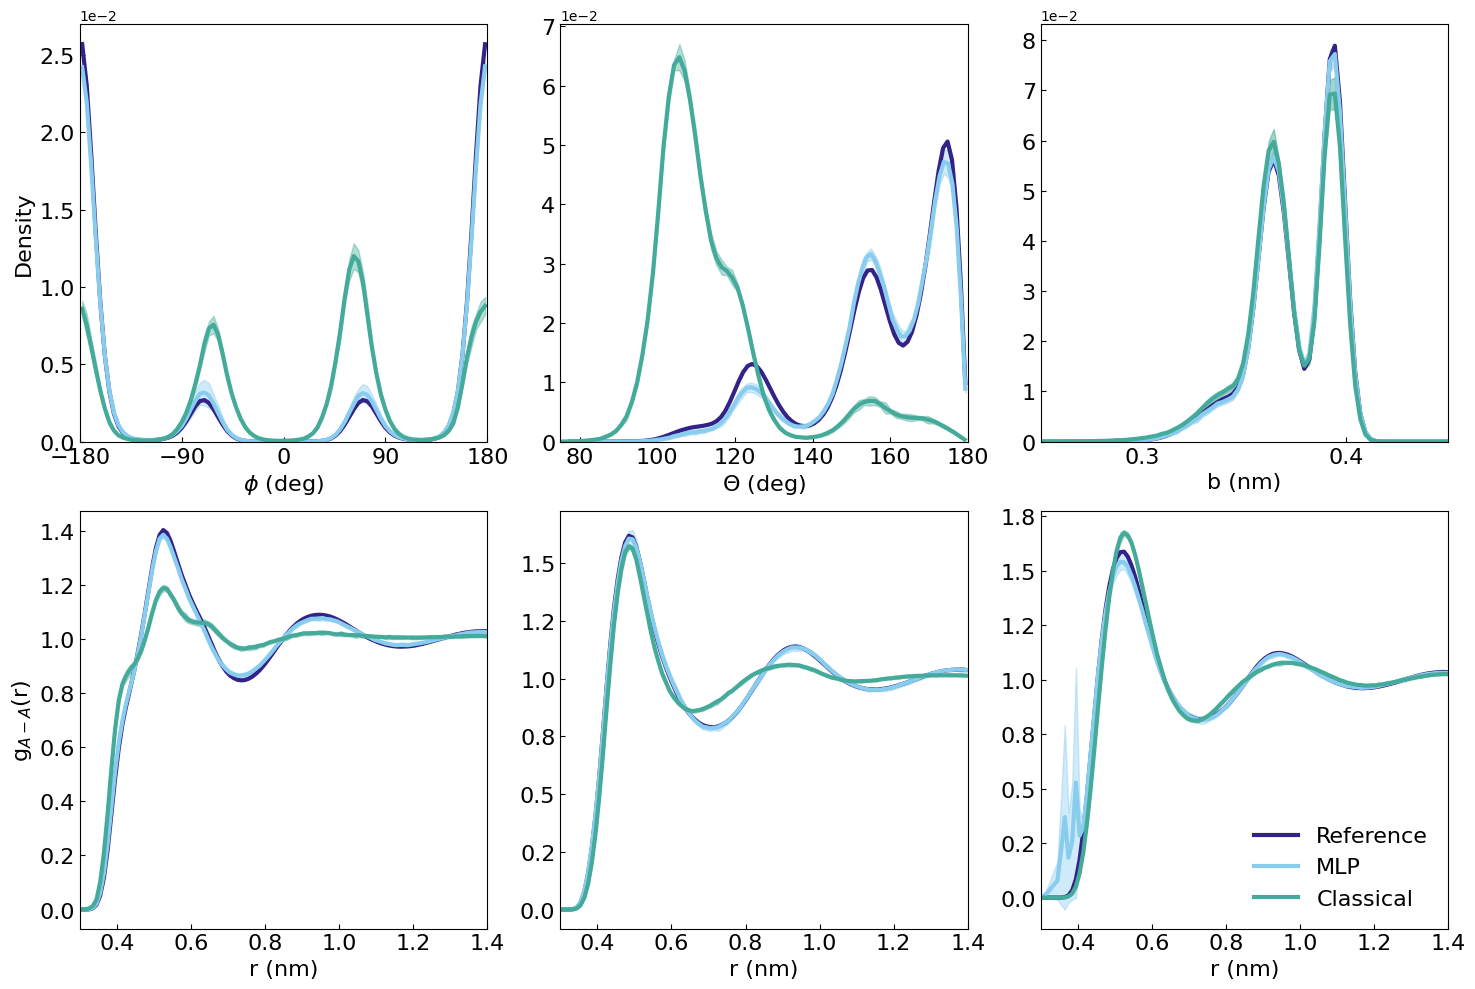

In [139]:
import importlib
import structural_analysis_utils
importlib.reload(structural_analysis_utils)
import matplotlib.pyplot as plt

labels = [
    'Reference', 
    'MLP', 
    'Classical'
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
plt.subplots_adjust(hspace=0.2, wspace=0.2)  # Adjust spacing between subplots

structural_analysis_utils.plot_1d_dihedral(
    axes[0, 0], 
    [
        results['four-site']['ref']['dihedrals'],
        results['four-site']['mace'][N][bo]['dihedrals'][:n_chains,],
        results['four-site']['classical']['dihedrals']
    ],
    ['Reference', 'MACE', 'Classical'],
    bins=90,
    ylabel=True,
    plot_legend=False,
    xlabel='$\phi$ (deg)',
    tick_bin=90,
    mode='multi',
    n_std=n_std,
)

structural_analysis_utils.plot_1d_angle(
    axes[0, 1], 
    [
        results['three-site']['ref']['angles'],
        results['three-site']['mace'][N][bo]['angles'][:n_chains,],
        results['three-site']['classical']['angles']
    ],  
    ['Reference', 'MLP', 'Classical'],
    bins=90,
    ylabel=False,
    plot_legend=False,
    xlabel='$\Theta$ (deg)',
    degrees=True,
    mode='multi',
    n_std=n_std,
)
axes[0, 1].set_xlim(75, 180)

structural_analysis_utils.plot_1d_bond(
    axes[0, 2], 
    [
        results['two-site']['ref']['bonds'],
        results['two-site']['mace'][N][bo]['nn_distances'][:n_chains,],
        results['two-site']['classical']['bonds']
    ],
    [
        'Reference', 
        'MACE (Nearest Neighbor)', 
        'Classical'
    ],
    bins=150,
    plot_legend=False,
    ylabel=False,
    xlabel='b (nm)',
    tick_bin=0.1,
    mode='multi',
    n_std=n_std,
)
axes[0, 2].set_xlim(0.25, 0.45)


structural_analysis_utils.plot_1d_rdf(
    axes[1, 0], 
    results['four-site']['rdf'], 
    ('A', 'A'), 
    labels, 
    ylabel=True,
    plot_legend=False,
    mode='multi',
    n_std=n_std,
)
axes[1, 0].set_xlim(0.3, 1.4)

structural_analysis_utils.plot_1d_rdf(
    axes[1, 1], 
    results['three-site']['rdf'], 
    ('A', 'A'), 
    labels, 
    ylabel=False,
    plot_legend=False,
    mode='multi',
    n_std=n_std,
)
axes[1, 1].set_xlim(0.3, 1.4)

structural_analysis_utils.plot_1d_rdf(
    axes[1, 2], 
    results['two-site']['rdf'], 
    ('A', 'A'), 
    labels, 
    ylabel=False,
    plot_legend=True,
    mode='multi',
    n_std=n_std,
)
axes[1, 2].set_xlim(0.3, 1.4)


    
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt

# Reset formatters first
for i in range(2):
    for j in range(3):
        axes[i, j].yaxis.set_major_formatter(ScalarFormatter())

# Apply scientific notation
for i in range(2):
    for j in range(3):
        axes[i, j].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Override a specific axis with 1-decimal formatting
axes[1, 2].yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f'{x:.1f}')
)
# Override a specific axis with 1-decimal formatting
axes[1, 1].yaxis.set_major_formatter(
    plt.FuncFormatter(lambda x, _: f'{x:.1f}')
)


plt.tight_layout()
plt.savefig("Hexane/Hexane_combined_analysis.pdf", format='pdf', dpi=300, bbox_inches='tight')

Processing bond data for 'Reference': (100000000,)
Processing bond data for 'MLP': (9, 400000)
Plotting bond distribution for 'MLP': 9 chains, mean=1.0, std sum=0.010753507571253092
Processing bond data for 'Classical': (10, 400200)
Plotting bond distribution for 'Classical': 10 chains, mean=1.0, std sum=0.01030685549439278


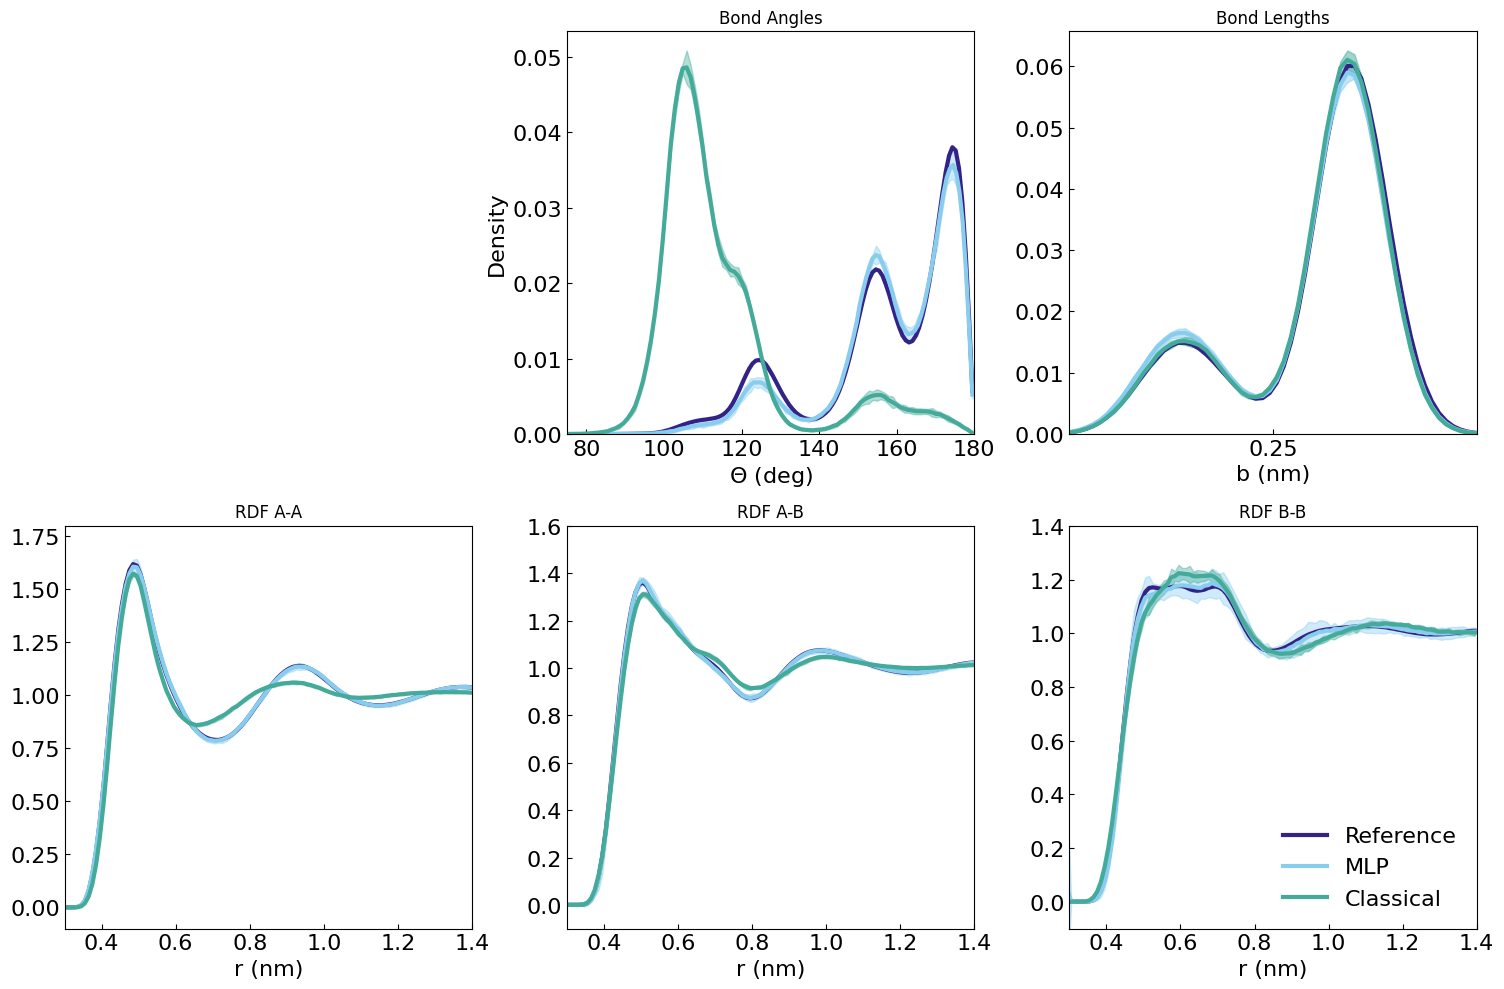

In [150]:
import matplotlib.pyplot as plt

# Create a 2-row, 3-column plot layout
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)  # Adjust spacing between subplots

# Leave the first cell empty
axes[0, 0].axis('off')



# Plot bond angles
plot_1d_angle(
    axes[0, 1],
    [
        results['three-site']['ref']['angles'],
        results['three-site']['mace'][N][bo]['angles'][:n_chains,],
        results['three-site']['classical']['angles']
    ],
    ['Reference', 'MLP', 'Classical'],
    bins=120,
    degrees=True,
    xlabel='$\\Theta$ (deg)',
    ylabel=True,
    plot_legend=False,
    mode='multi',
    n_std=n_std,
)
axes[0, 1].set_title('Bond Angles')
axes[0, 1].set_xlim(75, 180)

# Plot bond lengths
plot_1d_bond(
    axes[0, 2],
    [
        results['three-site']['ref']['bonds'],
        results['three-site']['mace'][N][bo]['bonds'][:n_chains,],
        results['three-site']['classical']['bonds']
    ],
    ['Reference', 'MLP', 'Classical'],
    bins=90,
    xlabel='b (nm)',
    ylabel=False,
    plot_legend=False,
    tick_bin=0.05,
    mode='multi',
    n_std=n_std,
)
axes[0, 2].set_title('Bond Lengths')
axes[0, 2].set_xlim(0.22, 0.28)

# Plot RDF for A-A
structural_analysis_utils.plot_1d_rdf(
    axes[1, 0], 
    results['three-site']['rdf'], 
    ('A', 'A'),
    labels,
    xlabel='r (nm)',
    ylabel=False,
    plot_legend=False,
    mode='multi',
    n_std=n_std,
)
axes[1, 0].set_title('RDF A-A')
axes[1, 0].set_xlim(0.3, 1.4)
axes[1, 0].set_ylim(-0.1, 1.8)

# Plot RDF for A-B
structural_analysis_utils.plot_1d_rdf(
    axes[1, 1], 
    results['three-site']['rdf'], 
    ('A', 'B'), 
    labels,
    xlabel='r (nm)',
    ylabel=False,
    plot_legend=False,
    mode='multi',
    n_std=n_std,
)
axes[1, 1].set_title('RDF A-B')
axes[1, 1].set_xlim(0.3, 1.4)
axes[1, 1].set_ylim(-0.1, 1.6)

# Plot RDF for B-B
structural_analysis_utils.plot_1d_rdf(
    axes[1, 2], 
    results['three-site']['rdf'], 
    ('B', 'B'), 
    labels,
    xlabel='r (nm)',
    ylabel=False,
    plot_legend=True,
    mode='multi',
    n_std=n_std,
)
axes[1, 2].set_title('RDF B-B')
axes[1, 2].set_xlim(0.3, 1.4)
axes[1, 2].set_ylim(-0.1, 1.4)

# Save the plot as a PDF
plt.tight_layout()
plt.savefig("Hexane/Three-site_combined_analysis.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

Processing bond data for 'Reference': (100000000,)
Processing bond data for 'MLP': (10, 400000)
Plotting bond distribution for 'MLP': 10 chains, mean=1.0, std sum=0.008957956613433269
Processing bond data for 'Classical': (10, 400200)
Plotting bond distribution for 'Classical': 10 chains, mean=0.9999999999999999, std sum=0.008930159101208174


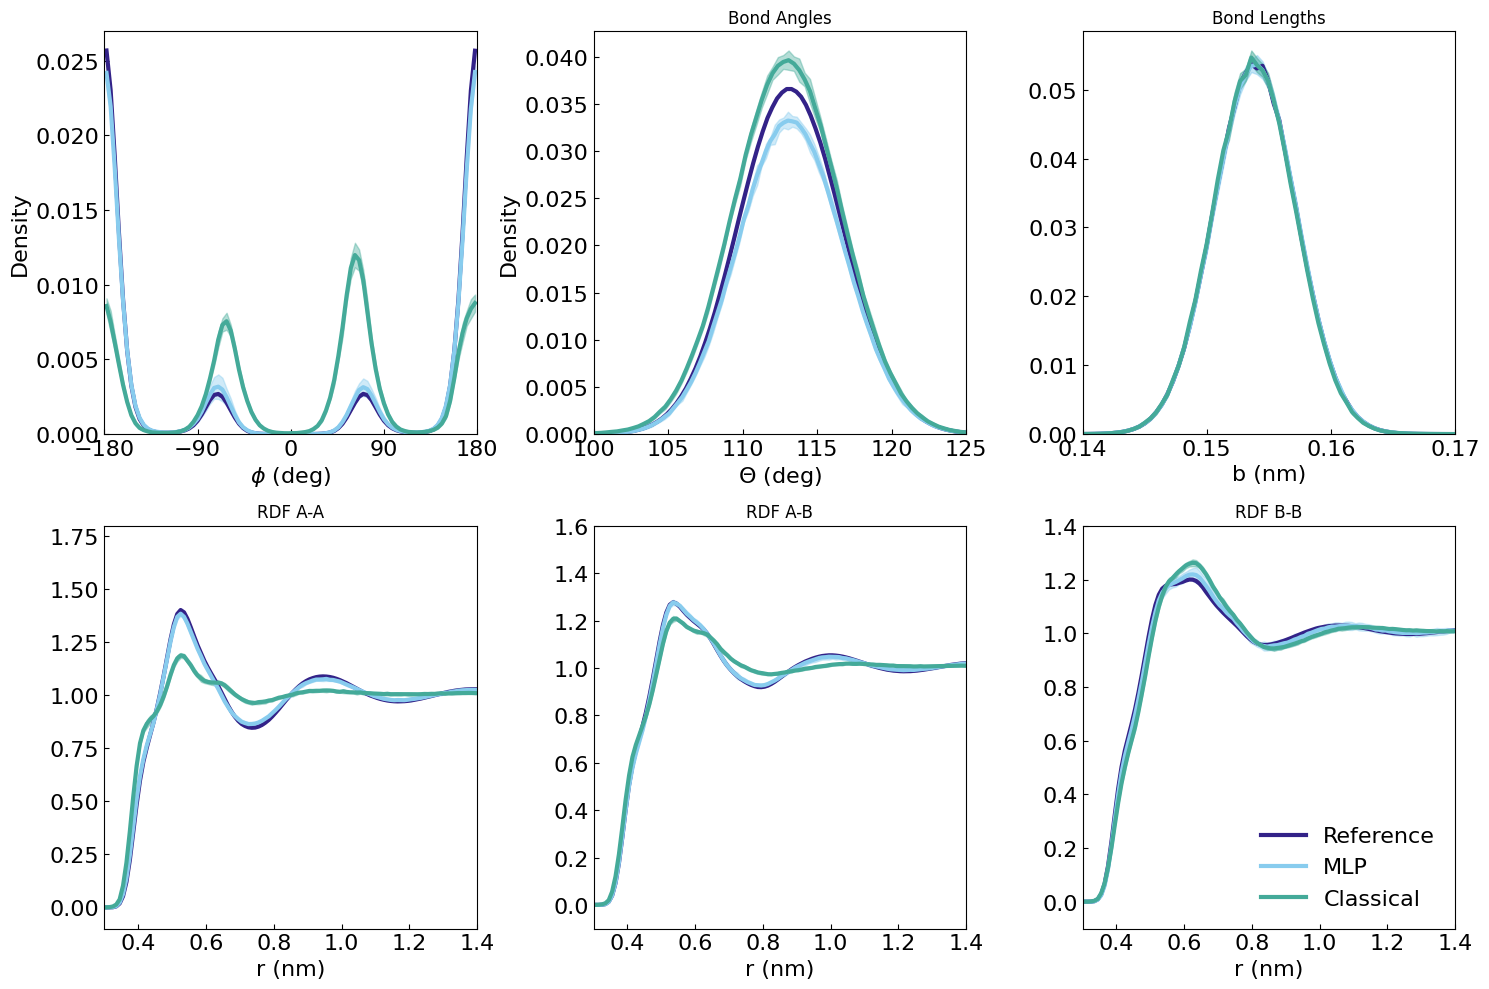

In [156]:
import matplotlib.pyplot as plt

# Create a 2-row, 3-column plot layout
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)  # Adjust spacing between subplots

structural_analysis_utils.plot_1d_dihedral(
    axes[0, 0], 
    [
        results['four-site']['ref']['dihedrals'],
        results['four-site']['mace'][N][bo]['dihedrals'][:n_chains,],
        results['four-site']['classical']['dihedrals']
    ],
    ['Reference', 'MACE', 'Classical'],
    bins=90,
    ylabel=True,
    plot_legend=False,
    xlabel='$\phi$ (deg)',
    tick_bin=90,
    mode='multi',
    n_std=n_std,
)


# Plot bond angles
plot_1d_angle(
    axes[0, 1],
    [
        results['four-site']['ref']['angles'],
        results['four-site']['mace'][N][bo]['angles'][:n_chains,],
        np.radians(results['four-site']['classical']['angles'])
    ],
    ['Reference', 'MLP', 'Classical'],
    bins=120,
    degrees=True,
    xlabel='$\\Theta$ (deg)',
    ylabel=True,
    plot_legend=False,
    mode='multi',
    n_std=n_std,
)
axes[0, 1].set_title('Bond Angles')
axes[0, 1].set_xlim(100,125)

# Plot bond lengths
plot_1d_bond(
    axes[0, 2],
    [
        results['four-site']['ref']['bonds'],
        results['four-site']['mace'][N][bo]['bonds'][:n_chains,],
        results['four-site']['classical']['bonds']
    ],
    ['Reference', 'MLP', 'Classical'],
    bins=90,
    xlabel='b (nm)',
    ylabel=False,
    plot_legend=False,
    tick_bin=0.01,
    mode='multi',
    n_std=n_std,
)
axes[0, 2].set_title('Bond Lengths')
axes[0, 2].set_xlim(0.14, 0.17)

# Plot RDF for A-A
structural_analysis_utils.plot_1d_rdf(
    axes[1, 0], 
    results['four-site']['rdf'], 
    ('A', 'A'),
    labels,
    xlabel='r (nm)',
    ylabel=False,
    plot_legend=False,
    mode='multi',
    n_std=n_std,
)
axes[1, 0].set_title('RDF A-A')
axes[1, 0].set_xlim(0.3, 1.4)
axes[1, 0].set_ylim(-0.1, 1.8)

# Plot RDF for A-B
structural_analysis_utils.plot_1d_rdf(
    axes[1, 1], 
    results['four-site']['rdf'], 
    ('A', 'B'), 
    labels,
    xlabel='r (nm)',
    ylabel=False,
    plot_legend=False,
    mode='multi',
    n_std=n_std,
)
axes[1, 1].set_title('RDF A-B')
axes[1, 1].set_xlim(0.3, 1.4)
axes[1, 1].set_ylim(-0.1, 1.6)

# Plot RDF for B-B
structural_analysis_utils.plot_1d_rdf(
    axes[1, 2], 
    results['four-site']['rdf'], 
    ('B', 'B'), 
    labels,
    xlabel='r (nm)',
    ylabel=False,
    plot_legend=True,
    mode='multi',
    n_std=n_std,
)
axes[1, 2].set_title('RDF B-B')
axes[1, 2].set_xlim(0.3, 1.4)
axes[1, 2].set_ylim(-0.1, 1.4)

# Save the plot as a PDF
plt.tight_layout()
plt.savefig("Hexane/Four-site_combined_analysis.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Body Order Plots

In [159]:
results_body_order = {}
results_body_order['three-site'] = {
    'ref': results['three-site']['ref']
}

In [176]:
line_locs = utils.get_line_locations(0, 1000, 50, print_every=0.5)

###
path_int1_corr1 = "Hexane/MLP/Hexane_map=three-site_rcut=0.7_corr=1_int=1/simulation_NVT_T=300.0K/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=50_mode=sampling_seed=22/trajectory.pkl"
mace_traj = np.load(path_int1_corr1, allow_pickle=True)
mace_traj *= box[0,0]
mace_traj = utils.split_into_chains(mace_traj, line_locs)

angles_mace = [angle_util['three-site']['disp_X'](chain) for chain in mace_traj]  # [N_angle_idcs, n_frames]
angles_mace = [np.radians(np.concatenate(chain)) for chain in angles_mace]

bonds_mace = []
for chain in mace_traj:
    bonds_chain = []
    for a, b in bond_util['three-site']['idcs']:
        distances = utils.compute_atom_distance(chain, a, b, bond_util['three-site']['disp_X'])
        bonds_chain.append(distances)
    bonds_mace.append(np.concatenate(bonds_chain))


results_body_order['three-site']['int1_corr1'] = {
    'angles': np.array(angles_mace),
    'bonds': np.array(bonds_mace),
    'traj': mace_traj
}

###
path_int1_corr2 = "Hexane/MLP/Hexane_map=three-site_rcut=0.7_corr=2_int=1/simulation_NVT_T=300.0K/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=50_mode=sampling_seed=22/trajectory.pkl"
mace_traj = np.load(path_int1_corr2, allow_pickle=True)
mace_traj *= box[0,0]
mace_traj = utils.split_into_chains(mace_traj, line_locs)

angles_mace = [angle_util['three-site']['disp_X'](chain) for chain in mace_traj]  # [N_angle_idcs, n_frames]
angles_mace = [np.radians(np.concatenate(chain)) for chain in angles_mace]

bonds_mace = []
for chain in mace_traj:
    bonds_chain = []
    for a, b in bond_util['three-site']['idcs']:
        distances = utils.compute_atom_distance(chain, a, b, bond_util['three-site']['disp_X'])
        bonds_chain.append(distances)
    bonds_mace.append(np.concatenate(bonds_chain))

results_body_order['three-site']['int1_corr2'] = {
    'angles': np.array(angles_mace),
    'bonds': np.array(bonds_mace),
    'traj': mace_traj
}

###
path_int2_corr1 = "Hexane/MLP/Hexane_map=three-site_rcut=0.7_corr=1_int=2/simulation_NVT_T=300.0K/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=50_mode=sampling_seed=22/trajectory.pkl"
mace_traj = np.load(path_int2_corr1, allow_pickle=True)
mace_traj *= box[0,0]
mace_traj = utils.split_into_chains(mace_traj, line_locs)

angles_mace = [angle_util['three-site']['disp_X'](chain) for chain in mace_traj]  # [N_angle_idcs, n_frames]
angles_mace = [np.radians(np.concatenate(chain)) for chain in angles_mace]

bonds_mace = []
for chain in mace_traj:
    bonds_chain = []
    for a, b in bond_util['three-site']['idcs']:
        distances = utils.compute_atom_distance(chain, a, b, bond_util['three-site']['disp_X'])
        bonds_chain.append(distances)
    bonds_mace.append(np.concatenate(bonds_chain))

results_body_order['three-site']['int2_corr1'] = {
    'angles': np.array(angles_mace),
    'bonds': np.array(bonds_mace),
    'traj': mace_traj
}

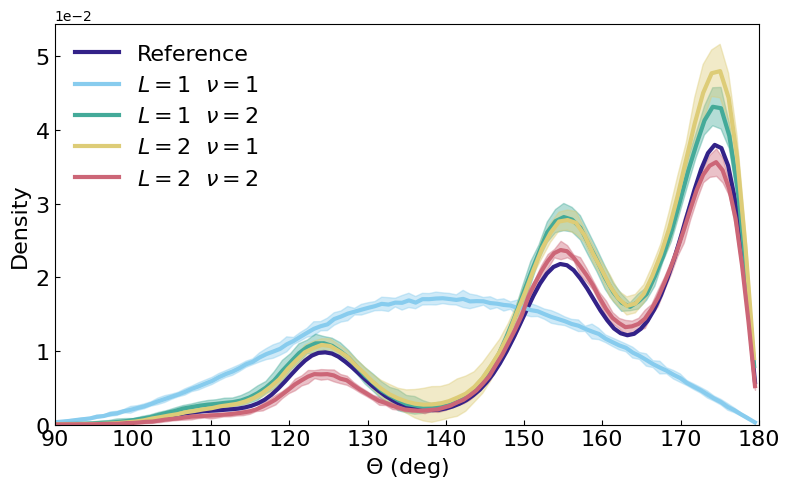

In [178]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.subplots_adjust(hspace=0.2, wspace=0.2)  # Adjust spacing between subplots

labels = ['Reference', r'$L=1$  $\nu=1$', r'$L=1$  $\nu=2$', r'$L=2$  $\nu=1$', r'$L=2$  $\nu=2$']

plot_1d_angle(
    ax, 
    [
        results_body_order['three-site']['ref']['angles'],
        results_body_order['three-site']['int1_corr1']['angles'][:n_chains,],
        results_body_order['three-site']['int1_corr2']['angles'][:n_chains,],
        results_body_order['three-site']['int2_corr1']['angles'][:n_chains,],
        results['three-site']['mace'][N][bo]['angles'][:n_chains,], # Re-use previous MACE data
    ],  
    labels,
    bins=120,
    ylabel=True,
    plot_legend=True,
    xlabel='$\Theta$ (deg)',
    degrees=True,
    mode='multi',
    n_std=3
)
plt.xlim(90, 180)
# make y-axis use scientific notation
ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

plt.tight_layout()
plt.savefig("Hexane/Three-site_Angle_L=1-2_v=1-2_std=3.pdf", format='pdf', dpi=300, bbox_inches='tight')

In [180]:
line_locs = utils.get_line_locations(0, 1000, 10, print_every=0.5)

results_body_order = {}
results_body_order['two-site'] = {
    'ref': results['two-site']['ref']
}
###
path_int1_corr1 = "Hexane/MLP/Hexane_map=two-site_rcut=0.8_corr=1_int=1/simulation_NVT/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=10_mode=sampling_seed=22/trajectory.pkl"
mace_traj = np.load(path_int1_corr1, allow_pickle=True)
mace_traj *= box[0,0]
mace_traj = utils.split_into_chains(mace_traj, line_locs)

bonds_mace = []
for chain in mace_traj:
    bonds_chain = []
    for a, b in bond_util['two-site']['idcs']:
        distances = utils.compute_atom_distance(chain, a, b, bond_util['two-site']['disp_X'])
        bonds_chain.append(distances)
    bonds_mace.append(np.concatenate(bonds_chain))

results_body_order['two-site']['int1_corr1'] = {
    'bonds': np.array(bonds_mace),
    'traj': mace_traj
}

###
path_int1_corr2 = "Hexane/MLP/Hexane_map=two-site_rcut=0.8_corr=2_int=1/simulation_NVT/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=10_mode=sampling_seed=22/trajectory.pkl"
mace_traj = np.load(path_int1_corr2, allow_pickle=True)
mace_traj *= box[0,0]
mace_traj = utils.split_into_chains(mace_traj, line_locs)

bonds_mace = []
for chain in mace_traj:
    bonds_chain = []
    for a, b in bond_util['two-site']['idcs']:
        distances = utils.compute_atom_distance(chain, a, b, bond_util['two-site']['disp_X'])
        bonds_chain.append(distances)
    bonds_mace.append(np.concatenate(bonds_chain))

results_body_order['two-site']['int1_corr2'] = {
    'bonds': np.array(bonds_mace),
    'traj': mace_traj
}

###
path_int2_corr1 = "Hexane/MLP/Hexane_map=two-site_rcut=0.8_corr=1_int=2/simulation_NVT/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=10_mode=sampling_seed=22/trajectory.pkl"
mace_traj = np.load(path_int2_corr1, allow_pickle=True)
mace_traj *= box[0,0]
mace_traj = utils.split_into_chains(mace_traj, line_locs)

bonds_mace = []
for chain in mace_traj:
    bonds_chain = []
    for a, b in bond_util['two-site']['idcs']:
        distances = utils.compute_atom_distance(chain, a, b, bond_util['two-site']['disp_X'])
        bonds_chain.append(distances)
    bonds_mace.append(np.concatenate(bonds_chain))

results_body_order['two-site']['int2_corr1'] = {
    'bonds': np.array(bonds_mace),
    'traj': mace_traj
}

###
path_int2_corr2 = "Hexane/MLP/Hexane_map=two-site_rcut=0.8_corr=2_int=2/simulation_NVT/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=10_mode=sampling_seed=22/trajectory.pkl"
mace_traj = np.load(path_int2_corr2, allow_pickle=True)
mace_traj *= box[0,0]
mace_traj = utils.split_into_chains(mace_traj, line_locs)

bonds_mace = []
for chain in mace_traj:
    bonds_chain = []
    for a, b in bond_util['two-site']['idcs']:
        distances = utils.compute_atom_distance(chain, a, b, bond_util['two-site']['disp_X'])
        bonds_chain.append(distances)
    bonds_mace.append(np.concatenate(bonds_chain))

results_body_order['two-site']['int2_corr2'] = {
    'bonds': np.array(bonds_mace),
    'traj': mace_traj
}

In [181]:
trajectories = [
    results_body_order['two-site']['ref']['traj'],
    results_body_order['two-site']['int1_corr1']['traj'],
    results_body_order['two-site']['int1_corr2']['traj'],
    results_body_order['two-site']['int2_corr1']['traj'],
    results_body_order['two-site']['int2_corr2']['traj'],
]

labels = [
    'Reference',
    r'$L=1$  $\nu=1$',
    r'$L=1$  $\nu=2$',
    r'$L=2$  $\nu=1$',
    r'$L=2$  $\nu=2$',    
]

# Determine chain counts
n_chains = trajectories[1].shape[0]   # model trajectories

# Identify which trajectories have no chain dimension (reference)
is_single_chain = [traj.ndim == 3 for traj in trajectories]

rdf_data_all_chains = []

# 1) Compute RDF for each chain
for chain in range(n_chains):
    trajs_single_chain = []
    for traj_chain, single in zip(trajectories, is_single_chain):
        if single:
            # Reference → do NOT index by chain
            trajs_single_chain.append(traj_chain)
        else:
            # ML models → pick chain
            trajs_single_chain.append(traj_chain[chain])

    rdf_data_chain, bead_combos = calculate_rdf(
        trajs_single_chain,
        ['A','A'],
        sites_per_mol=2,
        pair_batch_size=10_000,
        frame_batch_size=1_000
    )
    rdf_data_all_chains.append(rdf_data_chain)


Saved RDF plot for A-A pairs to rdf_A-A.pdf
Generated 1 RDF plots saved as PDF files.


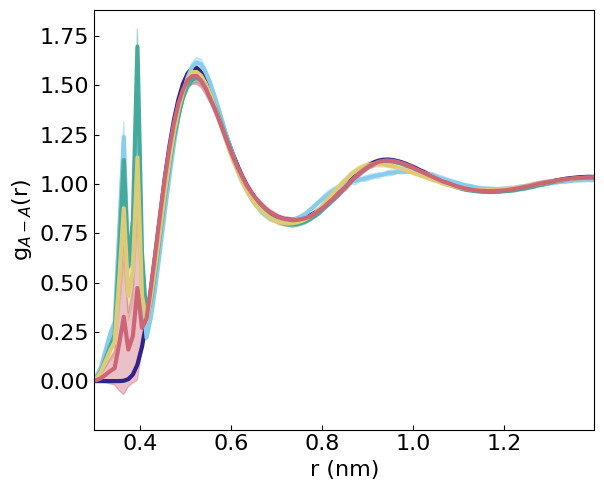

In [182]:
merged_rdf = {}

for bead_combo in bead_combos:
    merged_rdf[bead_combo] = {}

    for traj_idx in range(len(trajectories)):

        chain_curves = []
        for chain_idx in range(n_chains):
            r, g_r = rdf_data_all_chains[chain_idx][bead_combo][traj_idx]
            chain_curves.append((r, g_r))

        merged_rdf[bead_combo][traj_idx] = chain_curves


for bead_combo in bead_combos:
    for traj_idx in merged_rdf[bead_combo]:
        curves = merged_rdf[bead_combo][traj_idx]

        r_vals = np.array([c[0] for c in curves])   # shape (n_chains, bins)
        g_vals = np.array([c[1] for c in curves])   # shape (n_chains, bins)

        merged_rdf[bead_combo][traj_idx] = (r_vals, g_vals)


plot_rdf(
    merged_rdf,
    bead_combos,
    labels,
    mode="multi",   # enables mean + std shading
    n_std=3.0,
    show_legend=False
)


# NequIP

In [ ]:
results_nequip = {}

In [13]:
path = "Reference_simulations/hexane/hexane_ttot=100ns_dt=1fs_nstxout=200_CG=two-site.npz"
data = dict(np.load(path,allow_pickle=True))
ref_traj = np.concatenate([data['arr_0'].item()['training']['R'],data['arr_0'].item()['validation']['R']])

bond_ref = [utils.compute_atom_distance(ref_traj, a, b, bond_util['two-site']['disp_X']) for a,b in bond_util['two-site']['idcs']]
bond_ref = np.concatenate(bond_ref)

results_nequip['two-site'] = {
    'ref': {
        'bonds': bond_ref,
        'traj': ref_traj
    }
}

In [ ]:
traj_path = '/home/franz/CG-Mapping-Benchmark/MLP_train_nequip/Hexane_map=two-site_tr=0.9_epochs=50/simulation_NVT_T=300.0K/traj_mol=hexane_dt=2_teq=0_t=1000_nmol=100_nchains=10_mode=sampling_seed=22/trajectory.pkl'
nequip_traj = np.load(traj_path, allow_pickle=True)
    
assert nequip_traj.shape[0] == 20000
nequip_traj *= box[0,0]

bond_nequip = [utils.compute_atom_distance(nequip_traj, a, b, bond_util['two-site']['disp_X']) for a,b in bond_util['two-site']['idcs']]
bond_nequip = np.concatenate(bond_nequip)

results_nequip['two-site']['nequip'] = {
    'bonds': bond_nequip,
    'traj': nequip_traj
}

cumulative_fraction, nearest_neighbor_distances, bonds_per_frame = \
    compute_bond_metrics(nequip_traj, bond_util['two-site']['disp_X'])

results_nequip['two-site']['nequip']['cumulative_switch_fraction'] = cumulative_fraction
results_nequip['two-site']['nequip']['nn_distances'] = nearest_neighbor_distances
results_nequip['two-site']['nequip']['bonds_per_frame'] = bonds_per_frame

In [ ]:
trajectories = [
    results_nequip['two-site']['ref']['traj'],
    results_nequip['two-site']['nequip']['traj'],
]
labels = [
    'Reference', 
    'NequIP (Bonds)', 
]

rdf_data, bead_combos = calculate_rdf(
    trajectories, 
    ['A', 'A'], 
    sites_per_mol=2,
    pair_batch_size=10_000,
    frame_batch_size=1_000 
)

results_nequip['two-site']['rdf'] = {
    'data': rdf_data,
    'combos': bead_combos,
    'labels': labels
}

plot_rdf(rdf_data, bead_combos, labels, save_pdf=True, output_prefix='NequIP')

ValueError: axis 1 is out of bounds for array of dimension 1

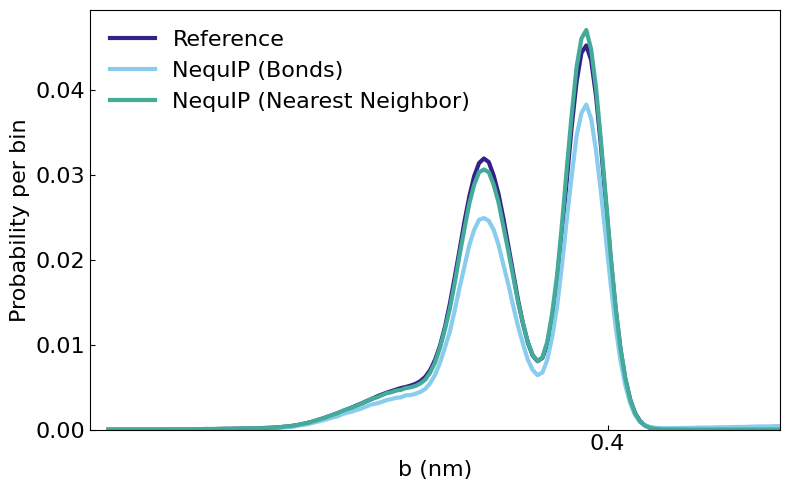

In [37]:
# make 

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1, figsize=(8, 5))

plot_1d_bond(
    axes, 
    [
        results_nequip['two-site']['ref']['bonds'],
        results_nequip['two-site']['nequip']['bonds'],
        results_nequip['two-site']['nequip']['nn_distances'].flatten(),
    ],
    [
        'Reference', 
        'NequIP (Bonds)', 
        'NequIP (Nearest Neighbor)', 
    ],
    bins=1500,
    plot_legend=True,
    ylabel=True,
    xlabel='b (nm)',
    tick_bin=0.4
)
plt.xlim(0.25, 0.45)
plt.tight_layout()
plt.savefig("NequIP_Two-site_Bond_Nearest_Neighbor.pdf", format='pdf', dpi=300, bbox_inches='tight')